# Parts 1-3: Word2Vec

This project will have you implementing word2vec using PyTorch and let you familiarize yourself with building more complex neural networks and the larger PyTorch development infrastructure.

Broadly, this project consists of a few major parts:
1. Implement a `Corpus` class that will load the dataset and convert it to a sequence of token ids
2. Implement negative sampling to select tokens to be used as negative examples of words in the context
3. Create your dataset of positive and negative examples per context and load it into PyTorch's `DataLoader` to use for sampling
4. Implement a `Word2Vec` class that is a PyTorch neural network
5. Implement a training loop that samples a _batch_ of target words and their respective positive/negative context words
6. Implement rare word removal and frequent word subsampling
7. Run your model on the full dataset for at least one epoch
8. Do the exploratory parts of the project
9. Save vectors and word-indexing data for later use in training a classifier

After Step 5, you should be able to run your word2vec implementation on a small dataset and verify that it's learning correctly. Once you can verify everything is working, proceed with steps 6 and beyond. 

### Estimated performance times

We designed this project to be run on a laptop-grade CPU, so no GPU is required. If your primary computing device is a tablet or similar device, this project can also be _developed_ on that device but then run on a more powerful machine in the Great Lakes cluster (for free). Such cases are the exception though. Following, we report on the estimated times from our reference implementation for longer-running or data-intensive pieces of the project. Your timing may vary based on implementation design; major differences in time (e.g., 10x longer) usually point to a performance bug.

* Reading and tokenizing: ~5 seconds
* Subsampling and converting to token ids: ~15 seconds
* Generating the list of training examples: ~15 minutes
* Training one epoch: ~12 minutes

A quick note: the code that generates training instances is probably slower than it needs to be based on how we've described the process. The instructions make generating training tuples conceptually easier by breaking it into steps. _However_, the steps introduce a subtle performance bug from sampling random numbers one at a time when we really need a lot of them (particularly for the negative samples). Fixing this performance but will cause the training data to be generated in ~20% of the time but makes the code a bit ugly to read. Since you only need to generate the training instances once (and could even save these to disk if needed) we've kept the instructions as is. However, if you decide to scale up to the bigger corpora, you might dig into the cell that calls `generate_negative_samples`. 

In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from tqdm.auto import tqdm, trange
from collections import Counter
import random
from torch import optim
import math
import nltk
import spacy
import ipywidgets

from torch.utils.tensorboard import SummaryWriter

# Helpful for computing cosine similarity--Note that this is NOT a similarity!
from scipy.spatial.distance import cosine

# Handy command-line argument parsing
import argparse

# Sort of smart tokenization
from nltk.tokenize import RegexpTokenizer

# We'll use this to save our models
from gensim.models import KeyedVectors

import pickle

stop_words = nltk.corpus.stopwords.words('english')
# Load the English language model in spaCy
# nlp = spacy.load('en_core_web_sm')

# Get the STOP_WORDS set for English
# stop_words = nlp.Defaults.stop_words

#
# IMPORTANT NOTE: Always set your random seeds when dealing with stochastic
# algorithms as it lets your bugs be reproducible and (more importantly) it lets
# your results be reproducible by others.
#
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

## Create a class to hold the data

Before we get to training word2vec, we'll need to process the corpus into some representation. The `Corpus` class will handle much of the functionality for corpus reading and keeping track of which word types belong to which ids. The `Corpus` class will also handle the crucial functionality of generating negative samples for training (i.e., randomly-sampled words that were not in the target word's context).

Some parts of this class can be completed after you've gotten word2vec up and running, so see the notes below and the details in the homework PDF.

In [31]:
class Corpus:
    
    def __init__(self):

        # self.tokenizer = RegexpTokenizer(r'\w+')
        # self.tokenizer = RegexpTokenizer(r"\w+(?:'\w+)?")
        self.tokenizer = RegexpTokenizer("[\w'-]+(?<!\d)")
        
        # These state variables become populated with function calls
        #
        # 1. load_data()
        # 2. generate_negative_sampling_table()
        #
        # See those functions for how the various values get filled in

        self.word_to_index = {} # word to unique-id
        self.index_to_word = {} # unique-id to word

        # How many times each word occurs in our data after filtering
        self.word_counts = Counter()

        # A utility data structure that lets us quickly sample "negative"
        # instances in a context. This table contains unique-ids
        self.negative_sampling_table = []
        
        # The dataset we'll use for training, as a sequence of unqiue word
        # ids. This is the sequence across all documents after tokens have been
        # randomly subsampled by the word2vec preprocessing step
        self.full_token_sequence_as_ids = []
        
    def tokenize(self, text):
        '''
        Tokenize the document and returns a list of the tokens
        '''
        return self.tokenizer.tokenize(text)        

    def load_data(self, file_name, min_token_freq):
        '''
        Reads the data from the specified file as long long sequence of text
        (ignoring line breaks) and populates the data structures of this
        word2vec object.
        '''

        # Step 1: Read in the file and create a long sequence of tokens for
        # all tokens in the file
        print('Reading data and tokenizing')
        all_tokens = []

        with open(file_name) as f:
            text = f.read()
        all_tokens = self.tokenizer.tokenize(text.lower())
        total = len(all_tokens)
    
        # Step 2: Count how many tokens we have of each type
        print('Counting token frequencies')
        self.word_counts = Counter(all_tokens)

        # Step 3: Replace all tokens below the specified frequency with an <UNK>
        # token. 
        #
        # NOTE: You can do this step later if needed
        print("Performing minimum thresholding")
       
        all_tokens_filter = [tokens for tokens in all_tokens if self.word_counts[tokens] >= 5]
        unk_count = total - len(all_tokens_filter)

        # Step 4: update self.word_counts to be the number of times each word
        # occurs (including <UNK>)
        self.word_counts = Counter(all_tokens_filter)
        self.word_counts['<UNK>'] = unk_count
        word_counts_stop = self.word_counts

        print("Performing stop-word removal")
        self.word_counts = {w: c for (w, c) in self.word_counts.items() if w not in stop_words}

        # Step 5: Create the mappings from word to unique integer ID and the
        # reverse mapping.

        self.word_to_index = {word: i for i, word in enumerate(self.word_counts.keys())}
        self.index_to_word = {i: word for word, i in self.word_to_index.items()}
        
        # Step 6: Compute the probability of keeping any particular *token* of a
        # word in the training sequence, which we'll use to subsample. This subsampling
        # avoids having the training data be filled with many overly common words
        # as positive examples in the context
    
        total_count = sum(self.word_counts.values()) - unk_count
        # self.word_to_sample_probs = {word: 1 - math.sqrt(min_token_freq / (count / total_count)) for word, count in self.word_counts.items()}

        word_to_sample_prob = {}
        for token, count in self.word_counts.items():
            if token != '<UNK>':
                freq = count / total_count
                prob = (np.sqrt(freq / 0.001) + 1) * (0.001 / freq)
                if  prob <= 1: word_to_sample_prob[token] = prob
                else: word_to_sample_prob[token] = 1
        
        # Step 7: process the list of tokens (after min-freq filtering) to fill
        # a new list self.full_token_sequence_as_ids where 
        #
        # (1) we probabilistically choose whether to keep each *token* based on the
        # subsampling probabilities (note that this does not mean we drop
        # an entire word!) and 
        #
        # (2) all tokens are convered to their unique ids for faster training.
        #
        # NOTE: You can skip the subsampling part and just do step 2 to get
        # your model up and running.
            
        # NOTE 2: You will perform token-based subsampling based on the probabilities in
        # word_to_sample_prob. When subsampling, you are modifying the sequence itself 
        # (like deleting an item in a list). This action effectively makes the context
        # window  larger for some target words by removing context words that are common
        # from a particular context before the training occurs (which then would now include
        # other words that were previously just outside the window).

        all_tokens_unk = [token if token in word_counts_stop.keys() else '<UNK>' for token in all_tokens ]
        for token in all_tokens_unk:
            if token in stop_words: 
                self.full_token_sequence_as_ids.append(-1)
                continue
            i = random.random()
            if i <= word_to_sample_prob.get(token, 100): 
                self.full_token_sequence_as_ids.append(self.word_to_index.get(token))
        
        # Helpful print statement to verify what you've loaded
        print('Loaded all data from %s; saw %d tokens (%d unique)' \
              % (file_name, len(self.full_token_sequence_as_ids),
                 len(self.word_to_index)))
    
    def generate_negative_sampling_table(self, exp_power=0.75, table_size=1e6):
        '''
        Generates a big list data structure that we can quickly randomly index into
        in order to select a negative training example (i.e., a word that was
        *not* present in the context). 
        '''
           
        
        # Step 1: Figure out how many instances of each word need to go into the
        # negative sampling table. 
        #
        # HINT: np.power and np.fill might be useful here        
        print("Generating sampling table")

        word_freq = np.power([count for word, count in self.word_counts.items() if word != '<UNK>'], exp_power)
        word_freq /= np.sum(word_freq)
        
        # Compute the number of instances of each word to put in the table
        table_counts = np.round(word_freq * table_size).astype(np.int32)

        # Step 2: Create the table to the correct size. You'll want this to be a
        # numpy array of type int
        table = np.zeros(int(np.sum(table_counts)), dtype=np.int32)

        # Step 3: Fill the table so that each word has a number of IDs
        # proportionate to its probability of being sampled.
        #
        # Example: if we have 3 words "a" "b" and "c" with probabilites 0.5,
        # 0.33, 0.16 and a table size of 6 then our table would look like this
        # (before converting the words to IDs):
        #
        # [ "a", "a", "a", "b", "b", "c" ]
        #

        table = np.random.choice(len(self.word_to_index) - 1, size=int(np.sum(table_counts)), p=word_freq).tolist()
        self.negative_sampling_table = table

    def generate_negative_samples(self, cur_context_word_id, num_samples):
        '''
        Randomly samples the specified number of negative samples from the lookup
        table and returns this list of IDs as a numpy array. As a performance
        improvement, avoid sampling a negative example that has the same ID as
        the current positive context word.
        '''

        # Create a list and sample from the negative_sampling_table to
        # grow the list to num_samples, avoiding adding a negative example that
        # has the same ID as the current context_word

        # Avoid adding negative examples that have the same ID as the current context_word

        while True:
            negative_samples = random.sample(self.negative_sampling_table, num_samples)
            check_exist = [id for id in negative_samples if id in cur_context_word_id ]
            if len(check_exist) == 0: break
            
        
        return np.array(negative_samples)


## Create the corpus

Now that we have code to turn the text into training data, let's do so. We've provided several files for you to help:

* `wiki-bios.DEBUG.txt` -- use this to debug your corpus reader
* `wiki-bios.10k.txt` -- use this to debug/verify the whole word2vec works
* `wiki-bios.med.txt` -- use this when everything works to generate your vectors for later parts
* `wiki-bios.HUGE.txt.gz` -- _do not use this_ unless (1) everything works and (2) you really want to test/explore. This file is not needed at all to do your homework.

We recommend startin to debug with the first file, as it is small and fast to load (quicker to find bugs). When debugging, we recommend setting the `min_token_freq` argument to 2 so that you can verify that part of the code is working but you still have enough word types left to test the rest.

You'll use the remaining files later, where they're described.

In the next cell, create your `Corpus`, read in the data, and generate the negative sampling table.

In [32]:
# random.seed(42)

corpus = Corpus()
corpus.load_data('reviews-word2vec.med.txt', 5)
corpus.generate_negative_sampling_table()

Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Performing stop-word removal
Loaded all data from reviews-word2vec.med.txt; saw 9850502 tokens (30170 unique)
Generating sampling table


## Generate the training data

Once we have the corpus ready, we need to generate our training dataset. Each instance in the dataset is a target word and positive and negative examples of contexts words. Given the target word as input, we'll want to predict (or not predict) these positive and negative context words as outputs using our network. Your task here is to create a python `list` of instances. 

Your final training data should be a list of tuples in the format ([target_word_id], [word_id_1, ...], [predicted_labels]), where each item in the list is a list:
1. The first item is a list consisting only of the target word's ID.
2. The second item is a list of word ids for both context words and negative samples 
3. The third item is a list of labels to predicted for each of the word ids in the second list (i.e., `1` for context words and `0` for negative samples). 

You will feed these tuples into the PyTorch `DatasetLoader` later that will do the converstion to `Tensor` objects. You will need to make sure that all of the lists in each tuple are `np.array` instances and are not plain python lists for this `Tensor` converstion to work.

In [33]:
np.random.seed(42)

window_size = 2
num_negative_samples_per_target = 2

training_data = []
# Determine the maximum number of context words for any instance
max_context_words = window_size * 2 + num_negative_samples_per_target * window_size * 2

# Loop through each token in the corpus and generate an instance for each, 
# adding it to training_data
for i, target_id in tqdm(enumerate(corpus.full_token_sequence_as_ids)):

    # For exach target word in our dataset, select context words 
    # within +/- the window size in the token sequence
    if target_id == -1 or target_id == 30169:
        continue
    
    # Deal with stop words
    context_id = []
    for j in range(i-window_size, i+window_size+1):
        if j != i and j >= 0 and j < len(corpus.full_token_sequence_as_ids):
            # check if the current context word is a stop word
            if corpus.full_token_sequence_as_ids[j] != -1 and corpus.full_token_sequence_as_ids[j] != 30169:
                context_id.append(corpus.full_token_sequence_as_ids[j])

    # Convert the context_id list to a numpy array
    
    # print(f'{target_id}, {context_id}')

    # For each positive target, we need to select negative examples of
    # words that were not in the context. Use the num_negative_samples_per_target
    # hyperparameter to generate these, using the generate_negative_samples()
    # method from the Corpus class

    # Ensure that each instance has the same size
    num_negative_samples = num_negative_samples_per_target * window_size * 2 + (window_size * 2 - len(context_id))
    negative_samples = corpus.generate_negative_samples(context_id + [target_id], num_negative_samples)

    # Convert the negative_samples list to a numpy array
    negative_samples = np.array(list(negative_samples)).astype(np.int32)

    predict_labels = np.concatenate((np.ones(len(context_id)), np.zeros(len(negative_samples))), axis=0)

    context_id = np.array(context_id).astype(np.int32)
    context_id = np.concatenate((context_id, negative_samples), axis=0)

    # Create the training data instance and add it to the list
    instance = (np.array([target_id]).astype(np.int32), context_id, predict_labels)
    training_data.append(instance)


    # NOTE: this part might not make sense until later when you do the training 
    # so feel free to revisit it to see why it happens.
    #
    # Our training will use batches of instances together (compare that 
    # with HW1's SGD that used one item at a time). PyTorch will require
    # that all instances in a batches have the same size, which creates an issue
    # for us here since the target wordss at the very beginning or end of the corpus
    # have shorter contexts. 
    # 
    # To work around these edge-cases, we need to ensure that each instance has
    # the same size, which means it needs to have the same number of positive
    # and negative examples. Since we are short on positive examples here (due
    # to the edge of the corpus), we can just add more negative samples.
    #
    # YOUR TASK: determine what is the maximum number of context words (positive
    # and negative) for any instance and then, for instances that have fewer than
    # this number of context words, add in negative examples.
    #
    # NOTE: The maximum is fixed, so you can precompute this outside the loop
    # ahead of time.

0it [00:00, ?it/s]

In [10]:
len(training_data)

4528296

## Create the network

We'll create a new neural network as a subclass of `nn.Module`. We do not need to used linear layers to implement word2vec. Instead, we will use PyTorch's `Emedding` class, which maps an index (e.g., a word id in this case) to an embedding. 

Roughly speaking, word2vec's network makes a prediction by computing the dot product of the target word's embedding and a context word's embedding and then passing this dot product through the sigmoid function ($\sigma$) to predict the probability that the context word was actually in the context.

In [34]:
class Word2Vec(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        self.embedding_size = embedding_size
        
        # Save what state you want and create the embeddings for your
        # target and context words
        self.target_embeddings = nn.Embedding(vocab_size, embedding_size)
        self.context_embeddings= nn.Embedding(vocab_size, embedding_size)
        
        # Once created, let's fill the embeddings with non-zero random
        # numbers. We need to do this to get the training started. 
        #
        # NOTE: Why do this? Think about what happens if all the embeddings
        # are all zeros initially. What would the predictions look like for
        # word2vec with these embeddings and how would the updated work?

        self.init_emb(init_range=0.5/vocab_size)
        
    def init_emb(self, init_range):
        
        # Fill your two embeddings with random numbers uniformly sampled
        # between +/- init_range
        self.target_embeddings.weight.data.uniform_(-init_range, init_range)
        self.context_embeddings.weight.data.uniform_(-init_range, init_range)
        
    def forward(self, target_word_id, context_word_ids):
        ''' 
        Predicts whether each context word was actually in the context of the target word.
        The input is a tensor with a single target word's id and a tensor containing each
        of the context words' ids (this includes both positive and negative examples).
        '''
    
        # NOTE 1: This is probably the hardest part of the project, so you'll
        # need to figure out how to do the dot-product between embeddings and return
        # the sigmoid. Be prepared for lots of debugging. For some reference,
        # our implementation is three lines and really the hard part is just
        # the last line. However, it's usually a matter of figuring out what
        # that one line looks like that ends up being the hard part.
        
        # NOTE 2: In this project you'll be dealing with *batches* of instances
        # rather than a single instance at once. PyTorch mostly handles this
        # seamlessly under the hood for you (which is very nice) but batching
        # can show in weird ways and create challenges in debugging initially.
        # For one, your inputs will get an extra dimension. So, for example,
        # if you have a batch size of 4, your input for target_word_id will
        # really be 4 x 1. If you get the embeddings of those targets,
        # it then becomes 4x50! The same applies to the context_word_ids, except
        # that was alreayd a list so now you have things with shape 
        #
        #    (batch x context_words x embedding_size)
        #
        # One of your tasks will be to figure out how to get things lined up
        # so everything "just works". When it does, the code looks surprisingly
        # simple, but it might take a lot of debugging (or not!) to get there.
        
        # NOTE 3: We *strongly* discourage you from looking for existing 
        # implementations of word2vec online. Sadly, having reviewed most of the
        # highly-visible ones, they are actually wrong (wow!) or are doing
        # inefficient things like computing the full softmax instead of doing
        # the negative sampling. Looking at these will likely leave you more
        # confused than if you just tried to figure it out yourself.
        
        # NOTE 4: There many ways to implement this, some more efficient
        # than others. You will want to get it working first and then
        # test the timing to see how long it takes. As long as the
        # code works (vector comparisons look good) you'll receive full
        # credit. However, very slow implementations may take hours(!)
        # to converge so plan ahead.
        
        
        # Hint 1: You may want to review the mathematical operations on how
        # to compute the dot product to see how to do these
        
        # Hint 2: the "dim" argument for some operations may come in handy,
        # depending on your implementation
        
        target_embeddings = self.target_embeddings(target_word_id)
        context_embeddings = self.context_embeddings(context_word_ids)

        # Compute the dot product between the target embedding and the context embeddings
        dot_product = torch.bmm(target_embeddings, context_embeddings.transpose(1,2)).squeeze()
        
        return torch.sigmoid(dot_product)

## Train the network!

Now that you have data in the right format and a neural network designed, it's time to train the network and see if it's all working.

For all steps, be sure to use the hyperparameters values described in the write-up.

1. Initialize your optimizer and loss function 
2. Create your network
3. Load your dataset into PyTorch's `DataLoader` class, which will take care of batching and shuffling for us (yay!)
4. Create a new `SummaryWriter` to periodically write our running-sum of the loss to a tensorboard
5. Train your model 

Two new elements show up. First, we'll be using `DataLoader` which is going to sample data for us and put it in a batch (and also convert the data to `Tensor` objects. You can iterate over the batches and each iteration will return all the items eventually, one batch at a time (a full epoch's worth).

The second new part is using `tensorboard`. As you might have noticed, training neural models can take some time. [TensorBoard](https://www.tensorflow.org/tensorboard/) is a handy web-based view that you can check during training to see how the model is doing. We'll use it here and periodically log a running sum of the loss after a set number of steps. We'll be doing something simple here with tensorboard but it will come in handy later as you train larger models (for longer) and may want to visually check if your model is converging. TensorBoard was initially written for another deep learning framework, TensorFlow, but proved so useful it was ported to work in PyTorch too and is [easy to integrate](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html).

To start training, we recommend training on the `wiki-bios.10k.txt` dataset. This data is small enough you can get through an epoch in a few minutes (or less) while still being large enough you can test whether the model is learning anything by examining common words. Below this cell we've added a few helper functions that you can use to debug and query your model. In particular, the `get_neighbors()` function is a great way to test: if your model has learned anything, the nearest neighbors for common words should seem reasonable (without having to jump through mental hoops). An easy word to test on the `10k` data is "january" which should return month-related words as being most similar.

**NOTE**: Since we're training biographies, the text itself will be skewed towards words likely to show up biographices--which isn't necessary like "regular" text. You may find that your model has few instances of words you think are common, or that the model learns poor or unusual neighbors for these. When querying the neighbors, it can help to think of which words you think are likely to show up in biographies on Wikipedia and use those as probes to see what the model has learned.

Once you're convinced the model is learning, switch to the `med` data and train your model as specified in the PDF. Once trained, save your model using the `save()` function at the end of the notebook. This function records your data in a common format for word2vec vectors and lets you load the vectors into other libraries that have more advanced functionality. In particular, you can use the [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) code in other notebook included to explore the vectors and do simple vector analogies.

In [52]:
# torch.manual_seed(1234)

# set hyperparameters
embedding_size = 50
lr = 0.0008
num_epochs = 3
batch_size = 512
vocab_size = len(corpus.word_counts) - 1

# create your network and initialize your optimizer and loss function 
model = Word2Vec(vocab_size, embedding_size)
optimizer = optim.AdamW(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

# Start tensorboard
writer = SummaryWriter('logs')
model.train()

# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(num_epochs):
    
    loss_sum = 0
    data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

    for step, data in enumerate(tqdm(data_loader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data 
        
        # print(f'[{target_ids}, {context_ids}]')
        # The training details
        optimizer.zero_grad()

        scores = model(target_ids, context_ids)
        loss = loss_fn(scores, labels.float())
        
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        if (step + 1) % 100 == 0:
            writer.add_scalar('Loss/train', loss_sum, epoch * len(data_loader) + step)
            loss_sum = 0
        
        if step > 10000:
            print('Reached max number of steps, stopping early.')
            break
        
model.eval()
writer.close()  

  0%|          | 0/8846 [00:00<?, ?it/s]

## Verify things are working

Once you have an initial model trained, try using the following code to query the model for what are the nearest neighbor of a word. This code is intended to help you debug

In [15]:
def get_neighbors(model, word_to_index, target_word):
    """ 
    Finds the top 10 most similar words to a target word
    """
    outputs = []
    for word, index in tqdm(word_to_index.items(), total=len(word_to_index)):
        similarity = compute_cosine_similarity(model, word_to_index, target_word, word)
        result = {"word": word, "score": similarity}
        outputs.append(result)

    # Sort by highest scores
    neighbors = sorted(outputs, key=lambda o: o['score'], reverse=True)
    return neighbors[1:11]

def compute_cosine_similarity(model, word_to_index, word_one, word_two):
    '''
    Computes the cosine similarity between the two words
    '''
    try:
        word_one_index = word_to_index[word_one]
        word_two_index = word_to_index[word_two]
    except KeyError:
        return 0

    embedding_one = model.target_embeddings(torch.LongTensor([word_one_index]))
    embedding_two = model.target_embeddings(torch.LongTensor([word_two_index]))
    similarity = 1 - abs(float(cosine(embedding_one.detach().squeeze().numpy(),
                                      embedding_two.detach().squeeze().numpy())))
    return similarity

In [37]:
word_to_index_unk = {k: v for (k, v) in corpus.word_to_index.items()}
word_to_index_unk.pop('<UNK>')
get_neighbors(model, word_to_index_unk, "recommend")

  0%|          | 0/30169 [00:00<?, ?it/s]

[{'word': 'reccomend', 'score': 0.9115572571754456},
 {'word': 'recomend', 'score': 0.9085889458656311},
 {'word': 'reccommend', 'score': 0.9071202278137207},
 {'word': 'recommed', 'score': 0.861479640007019},
 {'word': 'recomment', 'score': 0.8614442944526672},
 {'word': 'recommended', 'score': 0.8482457399368286},
 {'word': 'reccommended', 'score': 0.8317924737930298},
 {'word': 'suggest', 'score': 0.8293344974517822},
 {'word': 'regarded', 'score': 0.8115633726119995},
 {'word': 'endorse', 'score': 0.7867002487182617}]

In [38]:
get_neighbors(model, word_to_index_unk, "son")

  0%|          | 0/30169 [00:00<?, ?it/s]

[{'word': 'daughter', 'score': 0.9232931137084961},
 {'word': 'grandson', 'score': 0.8786094784736633},
 {'word': 'granddaughter', 'score': 0.871295154094696},
 {'word': 'husband', 'score': 0.8705027103424072},
 {'word': 'wife', 'score': 0.8700251579284668},
 {'word': 'niece', 'score': 0.8512646555900574},
 {'word': 'nephew', 'score': 0.8408806920051575},
 {'word': 'toddler', 'score': 0.8295501470565796},
 {'word': 'grandaughter', 'score': 0.8236208558082581},
 {'word': 'sister', 'score': 0.816752016544342}]

# Save your vectors for the gensim inspection part!

Once you have a fully trained model, save it using the code below. Note that we only save the `target_embeddings` from the model, but you could modify the code if you want to save the context vectors--or even try doing fancier things like saving the concatenation of the two or the average of the two!

In [40]:
def save(model, corpus, filename):
    '''
    Saves the model to the specified filename as a gensim KeyedVectors in the
    text format so you can load it separately.
    '''

    # Creates an empty KeyedVectors with our embedding size
    kv = KeyedVectors(vector_size=model.embedding_size)        
    vectors = []
    words = []
    # Get the list of words/vectors in a consistent order
    for index in trange(model.target_embeddings.num_embeddings):
        word = corpus.index_to_word[index]
        vectors.append(model.target_embeddings(torch.LongTensor([index])).detach().numpy()[0])
        words.append(word)

    # Fills the KV object with our data in the right order
    kv.add_vectors(words, vectors) 
    kv.save_word2vec_format(filename, binary=False)


# Save your vectors / data for the pytorch classifier in Part 4!

We'll be to using these vectors later in Part 4. We want to save them in a format that PyTorch can easily use. In particular you'll need to save the _state dict_ of the embeddings, which captures all of its information. 

In [41]:
filename = 'word2vec.kv'
save(model, corpus, filename)

  0%|          | 0/30169 [00:00<?, ?it/s]

We will also need the mapping from word to index so we can figure out which embedding to use for different words. Save the `corpus` objects mapping to a file using your preferred format (e.g., pickle or json).

In [44]:
import json

with open("word-to-index.json", "w") as outfile:
    json.dump(corpus.word_to_index, outfile, indent=4)

with open("index-to-word.json", "w") as outfile:
    json.dump(corpus.index_to_word, outfile, indent=4)

In [43]:
# Save embeddings
torch.save(model.target_embeddings.state_dict(), 'target_embedding_weights.pth')

#### Problem 12. 
Try batch sizes of 2, 8, 32, 64, 128, 256, 512 to see how fast each step (one batch worth of updates) is and the total estimated time. For this, you’ll set the parameter and then run the training long enough to get an estimate for both with tqdm wrapped around your batch iterator. You do not need to finish training for the full epoch. Make a plot where batch size is on the x-axis
10
and the tqdm-estimated time to finish one epoch is on the y-axis. (You may want to log-scale one or both of the axes). You can try other batch sizes too in this plot if you’re curious. In your write up, describe what you see. What batch size would you choose to maximize speed? Side note: You might also want to watch your memory usage, as larger batches can sometimes dramatically increase memory.

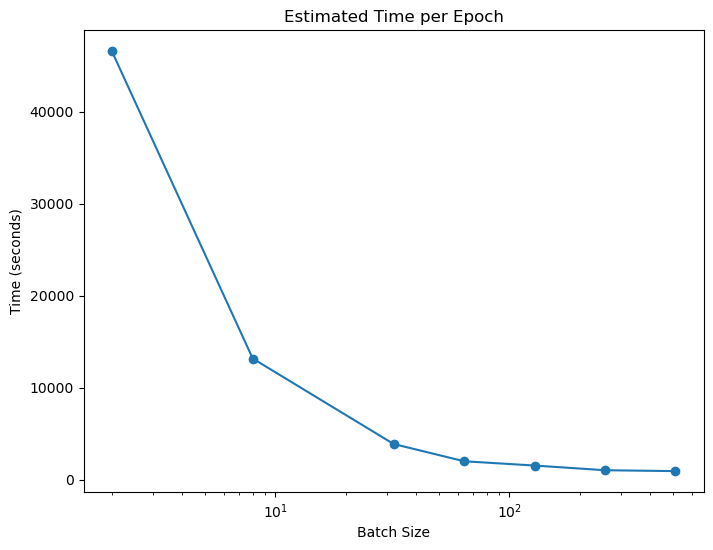

In [2]:
import matplotlib.pyplot as plt

bat_size = [2, 8, 32, 64, 128, 256, 512]
time_str = ["12:55:77", "3:39:22", "01:04:33", "00:33:18", "00:25:33", "00:17:03", "00:15:26"]

# Convert time to seconds
time_sec = []
for t in time_str:
    parts = t.split(':')
    sec = int(parts[0]) * 3600 + int(parts[1]) * 60 + int(parts[2])
    time_sec.append(sec)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(bat_size, time_sec, marker='o')
plt.xscale('log')
plt.xlabel('Batch Size')
plt.ylabel('Time (seconds)')
plt.title('Estimated Time per Epoch')
plt.show()
